In [ ]:
! pip install gensim

In [ ]:
!pip install -q textstat

In [ ]:
! pip install pymorphy2

In [ ]:
! pip install transformers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import nltk
nltk.download('stopwords')
import torch
import pickle
import string
import gensim
import logging
import numpy as np
import pandas as pd
from tqdm import tqdm
from pymorphy2 import MorphAnalyzer
from pymorphy2.tokenizers import simple_word_tokenize
from transformers import T5ForConditionalGeneration, T5Config, T5Tokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import word2vec
import urllib.request
from statistics import mean
import textstat

m = MorphAnalyzer()

stops = stopwords.words("russian")
tfidf = TfidfVectorizer(
    analyzer="word", 
    stop_words=stops
)

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## данные

### binary

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/RuATD/binary/train.csv')
train_df

,Id,Text,Class
0,0,"Обустройство тротуаров, мостовых (в том числе ...",H
1,1,Въ издержкахъ же оныхъ вы имете присылать счет...,H
2,2,"Положи это туда, откуда взял.",H
3,3,Минстрой обозначил способы снижения энергоемко...,M
4,4,В конце 1873 года военный суд вынес решение по...,M
...,...,...,...
129061,215102,Убытки МУП &quot;Теплоэнерго&nbsp;&ndash;. На ...,M
129062,215104,Три сестры были молодёжными послами на Национа...,H
129063,215105,В Прекрасной России Будущего коты создадут сво...,H
129064,215106,В семье наше будущее!,M


In [ ]:
train_df.value_counts('Class')

Class
H    64535
M    64531
dtype: int64

In [ ]:
val_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/RuATD/binary/original data/val.csv')
val_df

,Id,Text,Class
0,9,В связи с этим в подпрограмму включены следующ...,H
1,25,В последнее время я её нечасто видел.,H
2,27,"Лермонтов прибыл на Кавказ, чтобы задействоват...",M
3,30,Хотите фруктового сока?,H
4,62,"Однако, в рамках существующих условий «...",M
...,...,...,...
21506,215037,"Нет, не я, а ты!",H
21507,215040,"Кинолента ""Бегущий По Огню"" названа лучшей фил...",M
21508,215052,В настоящее время в городе работает более 200 ...,M
21509,215087,Российская теннисистка Мария Вавринка рассказа...,M


In [ ]:
val_df.value_counts('Class')

Class
H    10756
M    10755
dtype: int64

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/RuATD/binary/original data/test.csv')
test_df

,Id,Text
0,8,Деятельность по созданию новых рабочих мест и ...
1,12,12-18 июля 1944 года в схватке за мост на реке...
2,14,В целях реализации Федерального закона от 08.0...
3,16,Студент медик сказал что моя бессонница обосно...
4,17,В 1542 году король вновь заставил его внести в...
...,...,...
64528,215100,Вчера по дороге к Теплицу продолжали путь к Те...
64529,215101,Одной из приоритетных сфер деятельности В. П. ...
64530,215103,"Кстати, выбрать квартиру от ПЗСП и забронирова..."
64531,215108,Обама использовал это при планировании использ...


### multi

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/RuATD/multi/original data/train.csv')
train_df

,Id,Text,Class
0,0,"Программа, сроки и этапы реализации",M2M-100
1,1,Воскресенье. 10.30–11 час. репетиция (прогон в...,Human
2,3,Я много пива не пью.,OPUS-MT
3,9,Самцам тигров приходится успокаивать самку пер...,M2M-100
4,10,Разработанная в результате исследований методи...,Human
...,...,...,...
129061,215102,Октябрь был самый напряженный месяц по обстано...,Human
129062,215106,"Ты в нём первая пара, которая никому не сдалас...",mT5-Large
129063,215107,"По их данным, в Ирак в понедельник вылетели ок...",mT5-Large
129064,215108,Настя спасла станицу с ним.,mT5-Small


In [ ]:
x = []
for i in train_df.value_counts('Class'):
    x.append(i)

In [ ]:
classes

Class
Human                  51150
OPUS-MT                12087
M-BART50               11913
M2M-100                10817
ruGPT3-Large            9870
ruGPT3-Medium           7020
ruGPT3-Small            6930
mT5-Large               4860
mT5-Small               2940
ruT5-Base               2640
M-BART                  2510
ruGPT2-Large            2370
ruT5-Base-Multitask     2219
ruT5-Large              1740
dtype: int64

<BarContainer object of 14 artists>

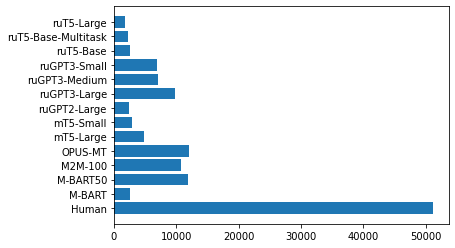

In [ ]:
classes = np.unique(train_df.Class, return_counts=True)
plt.barh(classes[0], classes[1])

In [ ]:
fig, ax = plt.subplots()

ax.bar(x, y)

ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(12)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure

plt.show()

In [ ]:
val_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/RuATD/multi/original data/val.csv')
val_df

,Id,Text,Class
0,2,Как насчёт ещё одного раунда?,OPUS-MT
1,8,К декабрю 1943 года старший лейтенант Николай ...,Human
2,24,Соловьев рассказал о просмотре в эфире одного ...,ruGPT3-Large
3,47,"Доброе утро, девочки и мальчики",mT5-Small
4,56,В октябре 2005 — докладчица на Европейском Кон...,M2M-100
...,...,...,...
21506,215089,Строев обвиняет в слабости центральных властей...,M2M-100
21507,215096,"Стерильны бывают и мужчины, но религиозная док...",M-BART
21508,215099,"Целый день в Pokémon Stadium, а потом еще и на...",ruGPT3-Large
21509,215103,Киев заплатит за газ лишь после согласования ц...,Human


In [ ]:
val_df.value_counts('Class')

Class
Human                  8524
OPUS-MT                2014
M-BART50               1986
M2M-100                1804
ruGPT3-Large           1645
ruGPT3-Medium          1170
ruGPT3-Small           1155
mT5-Large               810
mT5-Small               490
ruT5-Base               440
M-BART                  418
ruGPT2-Large            395
ruT5-Base-Multitask     370
ruT5-Large              290
dtype: int64

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/RuATD/multi/original data/test.csv')
test_df

## токенизация, лемматизация

In [ ]:
def tokens_lemmas(df, newname):
    """Tokenizes and lemmatizes text.

    Args:
        df: dataframe with texts 
            that need to be tokenized and lemmatized

    Returns:
        df: dataframe with a new column
    """
    tokens_df = []
    lemmas_df = []

    for text in tqdm(df['Text']):
        tokens = simple_word_tokenize(text)
        lemmas = []
        for token in tokens:
            if token not in string.punctuation:
                lemmas.append(
                    m.parse(token)[0].normal_form
                )

        tokens_df.append(tokens)
        lemmas_df.append(lemmas)
    
    df['Tokens'] = tokens_df
    df['Lemmas'] = lemmas_df

    df.to_csv(newname)

    return df

### binary

In [ ]:
tokens_lemmas(train_df, 'train_new.csv')

In [ ]:
tokens_lemmas(test_df, 'test_new.csv')

In [ ]:
tokens_lemmas(val_df, 'val_new.csv')

### multi

In [ ]:
tokens_lemmas(train_df, 'train_new.csv')

In [ ]:
val_df = tokens_lemmas(val_df, '1.csv')
val_df

100%|██████████| 21511/21511 [03:36<00:00, 99.24it/s] 


,Id,Text,Class,Tokens,Lemmas
0,2,Как насчёт ещё одного раунда?,OPUS-MT,"[Как, насчёт, ещё, одного, раунда, ?]","[как, насчёт, ещё, один, раунд]"
1,8,К декабрю 1943 года старший лейтенант Николай ...,Human,"[К, декабрю, 1943, года, старший, лейтенант, Н...","[к, декабрь, 1943, год, старший, лейтенант, ни..."
2,24,Соловьев рассказал о просмотре в эфире одного ...,ruGPT3-Large,"[Соловьев, рассказал, о, просмотре, в, эфире, ...","[соловьёв, рассказать, о, просмотр, в, эфир, о..."
3,47,"Доброе утро, девочки и мальчики",mT5-Small,"[Доброе, утро, ,, девочки, и, мальчики]","[добрый, утро, девочка, и, мальчик]"
4,56,В октябре 2005 — докладчица на Европейском Кон...,M2M-100,"[В, октябре, 2005, —, докладчица, на, Европейс...","[в, октябрь, 2005, —, докладчица, на, европейс..."
...,...,...,...,...,...
21506,215089,Строев обвиняет в слабости центральных властей...,M2M-100,"[Строев, обвиняет, в, слабости, центральных, в...","[строев, обвинять, в, слабость, центральный, в..."
21507,215096,"Стерильны бывают и мужчины, но религиозная док...",M-BART,"[Стерильны, бывают, и, мужчины, ,, но, религио...","[стерильный, бывать, и, мужчина, но, религиозн..."
21508,215099,"Целый день в Pokémon Stadium, а потом еще и на...",ruGPT3-Large,"[Целый, день, в, Pokémon, Stadium, ,, а, потом...","[целый, день, в, pokémon, stadium, а, потом, е..."
21509,215103,Киев заплатит за газ лишь после согласования ц...,Human,"[Киев, заплатит, за, газ, лишь, после, согласо...","[киев, заплатить, за, газ, лишь, после, соглас..."


In [ ]:
tokens_lemmas(test_df, 'test_new.csv')

## TF-IDF

In [ ]:
def tfifd(df, newname):
    """Vectorises texts.

    Args:
        df: dataframe with texts 
            that need to be vectorised
        
        newname: name of the file with return

    Returns:
        tfidfed: 
    """
    tfidfed = tfidf.fit_transform(tqdm(df.Text))
    np.save(newname, tfidfed)
    return tfidfed

### binary

In [ ]:
tfidfed = tfifd(train_df, 'train TF-IDF')

100%|██████████| 129066/129066 [00:07<00:00, 17678.05it/s]


In [ ]:
tfidfed_val = tfifd(val_df, 'val TF-IDF')

100%|██████████| 21511/21511 [00:00<00:00, 22299.82it/s]


### multi

In [ ]:
tfifd(train_df, 'train TF-IDF')

100%|██████████| 129066/129066 [00:06<00:00, 20987.48it/s]


<129066x293814 sparse matrix of type '<class 'numpy.float64'>'
	with 2765177 stored elements in Compressed Sparse Row format>

In [ ]:
tfifd(val_df, 'val TF-IDF')

100%|██████████| 21511/21511 [00:00<00:00, 22306.10it/s]


<21511x99573 sparse matrix of type '<class 'numpy.float64'>'
	with 461971 stored elements in Compressed Sparse Row format>

In [ ]:
tfifd(test_df, 'test TF-IDF')

100%|██████████| 64533/64533 [00:03<00:00, 20469.56it/s]


<64533x192982 sparse matrix of type '<class 'numpy.float64'>'
	with 1383407 stored elements in Compressed Sparse Row format>

## word2vec

### binary

In [ ]:
with open('train.txt', 'w') as f:
    for text in train_df.Text:
        f.write(text + '\n')

with open('val.txt', 'w') as f:
    for text in val_df.Text:
        f.write(text + '\n')

open('train.txt','w').write(open('/content/train.txt','r').read() + open('/content/val.txt','r').read())

f = '/content/trainval.txt'
data = gensim.models.word2vec.LineSentence(f)

In [ ]:
%time model = gensim.models.Word2Vec(data, size=300, window=5, min_count=2, iter=20)

2022-02-08 17:02:19,008 : INFO : collecting all words and their counts
2022-02-08 17:02:19,015 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-02-08 17:02:19,244 : INFO : PROGRESS: at sentence #10000, processed 269237 words, keeping 79638 word types
2022-02-08 17:02:19,474 : INFO : PROGRESS: at sentence #20000, processed 535357 words, keeping 130954 word types
2022-02-08 17:02:19,723 : INFO : PROGRESS: at sentence #30000, processed 807816 words, keeping 176101 word types
2022-02-08 17:02:19,966 : INFO : PROGRESS: at sentence #40000, processed 1076789 words, keeping 215150 word types
2022-02-08 17:02:20,229 : INFO : PROGRESS: at sentence #50000, processed 1345153 words, keeping 252491 word types
2022-02-08 17:02:20,488 : INFO : PROGRESS: at sentence #60000, processed 1617777 words, keeping 287768 word types
2022-02-08 17:02:20,748 : INFO : PROGRESS: at sentence #70000, processed 1890827 words, keeping 320946 word types
2022-02-08 17:02:21,035 : INFO : PRO

CPU times: user 13min 54s, sys: 7.69 s, total: 14min 2s
Wall time: 8min


In [ ]:
model.init_sims(replace=True)
model_path = "model.bin"

print("Saving model...")
model.wv.save_word2vec_format(model_path, binary=True)

2022-02-08 17:10:19,100 : INFO : precomputing L2-norms of word weight vectors
2022-02-08 17:10:21,080 : INFO : storing 188551x300 projection weights into model.bin


Saving model...


In [ ]:
print(len(model.wv.vocab))

188551


In [ ]:
word_vectors = model.wv
word_vectors.save("word2vec.wordvectors")

2022-02-08 17:43:19,769 : INFO : saving Word2VecKeyedVectors object under word2vec.wordvectors, separately None
2022-02-08 17:43:19,773 : INFO : storing np array 'vectors' to word2vec.wordvectors.vectors.npy
2022-02-08 17:43:21,201 : INFO : not storing attribute vectors_norm
2022-02-08 17:43:22,641 : INFO : saved word2vec.wordvectors


### multi

In [ ]:
with open('train.txt', 'w') as f:
    for text in train_df.Text:
        f.write(text + '\n')

with open('val.txt', 'w') as f:
    for text in val_df.Text:
        f.write(text + '\n')

In [ ]:
open('trainval.txt','w').write(open('/content/train.txt','r').read() + open('/content/val.txt','r').read())

34661262

In [ ]:
f = 'trainval.txt'
data = gensim.models.word2vec.LineSentence(f)

In [ ]:
%time model = gensim.models.Word2Vec(data, size=300, window=5, min_count=2, iter=20)

2022-02-08 18:47:28,631 : INFO : collecting all words and their counts
2022-02-08 18:47:28,636 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-02-08 18:47:28,826 : INFO : PROGRESS: at sentence #10000, processed 267836 words, keeping 78410 word types
2022-02-08 18:47:29,056 : INFO : PROGRESS: at sentence #20000, processed 537910 words, keeping 129909 word types
2022-02-08 18:47:29,293 : INFO : PROGRESS: at sentence #30000, processed 805594 words, keeping 173812 word types
2022-02-08 18:47:29,552 : INFO : PROGRESS: at sentence #40000, processed 1081320 words, keeping 214992 word types
2022-02-08 18:47:29,794 : INFO : PROGRESS: at sentence #50000, processed 1347669 words, keeping 251938 word types
2022-02-08 18:47:30,042 : INFO : PROGRESS: at sentence #60000, processed 1614154 words, keeping 286967 word types
2022-02-08 18:47:30,264 : INFO : PROGRESS: at sentence #70000, processed 1882733 words, keeping 319766 word types
2022-02-08 18:47:30,514 : INFO : PRO

CPU times: user 13min 17s, sys: 7.86 s, total: 13min 24s
Wall time: 8min 10s


In [ ]:
model.init_sims(replace=True)
model_path = "model.bin"

print("Saving model...")
model.wv.save_word2vec_format(model_path, binary=True)

2022-02-08 18:55:39,173 : INFO : precomputing L2-norms of word weight vectors
2022-02-08 18:55:41,139 : INFO : storing 188551x300 projection weights into model.bin


Saving model...


In [ ]:
print(len(model.wv.vocab))

188551


In [ ]:
word_vectors = model.wv
word_vectors.save("word2vec.wordvectors")

2022-02-08 18:55:43,893 : INFO : saving Word2VecKeyedVectors object under word2vec.wordvectors, separately None
2022-02-08 18:55:43,896 : INFO : storing np array 'vectors' to word2vec.wordvectors.vectors.npy
2022-02-08 18:55:44,713 : INFO : not storing attribute vectors_norm
2022-02-08 18:55:45,440 : INFO : saved word2vec.wordvectors


## длина предложений

In [ ]:
def lens(df, name, newfilename):
    symbols = []
    tokens = []
    for i, text in enumerate(tqdm(df.Text)):
        symbols.append(len(text))
        tokens.append(len(text.split()))
    df['len in symbols'] = symbols
    df['len in tokens'] = tokens
    print('\n\n')
    print(name)
    if 'Class' in df.columns:
        for cl in pd.unique(df.Class):
            print('\n')
            print(f'{cl}: средняя длина в символах:', df[df.Class==cl]['len in symbols'].mean())
            print(f'{cl}: средняя длина в токенах:', df[df.Class==cl]['len in tokens'].mean())
    else:
        print('Средняя длина в символах:', df['len in symbols'].mean())
        print('Средняя длина в токенах:', df['len in tokens'].mean())
            
    df.to_csv(newfilename)
    return df

### binary

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/RuATD/binary/processed data/train_new.csv')

In [ ]:
val_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/RuATD/binary/processed data/val_new.csv')

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/RuATD/binary/processed data/test_new.csv')

In [ ]:
train_df = lens(train_df, 'Train', 'train_processed.csv')
train_df

100%|██████████| 129066/129066 [00:00<00:00, 259386.66it/s]





Train


H: средняя длина в символах: 221.472022933292
H: средняя длина в токенах: 30.069497172077167


M: средняя длина в символах: 236.86135345802793
M: средняя длина в токенах: 31.847034758488167


,Unnamed: 0,Id,Text,Class,Tokens,Lemmas,len in symbols,len in tokens,vowels / symbols,white spaces / symbols,punctuation / symbols,mean word length,long words / all words,small words
0,0,0,"Обустройство тротуаров, мостовых (в том числе ...",H,"['Обустройство', 'тротуаров', ',', 'мостовых',...","['обустройство', 'тротуар', 'мостовый', 'в', '...",66,8,0.303,0.106,0.061,6.875,0.024,0.019
1,1,1,Въ издержкахъ же оныхъ вы имете присылать счет...,H,"['Въ', 'издержкахъ', 'же', 'оныхъ', 'вы', 'име...","['въ', 'издержкахъ', 'же', 'оныхъ', 'вы', 'име...",117,19,0.308,0.154,0.026,5.053,0.012,0.032
2,2,2,"Положи это туда, откуда взял.",H,"['Положи', 'это', 'туда', ',', 'откуда', 'взял...","['положить', 'это', 'туда', 'откуда', 'взять']",29,5,0.379,0.138,0.069,4.600,0.000,0.019
3,3,3,Минстрой обозначил способы снижения энергоемко...,M,"['Минстрой', 'обозначил', 'способы', 'снижения...","['минстрой', 'обозначить', 'способ', 'снижение...",71,7,0.380,0.085,0.014,9.143,0.022,0.000
4,4,4,В конце 1873 года военный суд вынес решение по...,M,"['В', 'конце', '1873', 'года', 'военный', 'суд...","['в', 'конец', '1873', 'год', 'военный', 'суд'...",76,13,0.329,0.158,0.013,4.846,0.000,0.025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129061,129061,215102,Убытки МУП &quot;Теплоэнерго&nbsp;&ndash;. На ...,M,"['Убытки', 'МУП', '&', 'quot', ';', 'Теплоэнер...","['убыток', 'муп', 'quot', 'теплоэнерго', 'nbsp...",538,71,0.348,0.130,0.037,5.831,0.020,0.035
129062,129062,215104,Три сестры были молодёжными послами на Национа...,H,"['Три', 'сестры', 'были', 'молодёжными', 'посл...","['три', 'сестра', 'быть', 'молодёжный', 'посол...",71,11,0.324,0.141,0.014,5.455,0.020,0.037
129063,129063,215105,В Прекрасной России Будущего коты создадут сво...,H,"['В', 'Прекрасной', 'России', 'Будущего', 'кот...","['в', 'прекрасный', 'россия', 'будущее', 'кот'...",153,23,0.340,0.144,0.026,5.522,0.014,0.025
129064,129064,215106,В семье наше будущее!,M,"['В', 'семье', 'наше', 'будущее', '!']","['в', 'семья', 'наш', 'будущее']",21,4,0.381,0.143,0.048,4.250,0.000,0.026


In [ ]:
val_df = lens(val_df, 'Val', 'val_processed.csv')
val_df

100%|██████████| 21511/21511 [00:00<00:00, 240860.45it/s]





Val


H: средняя длина в символах: 221.47052807735218
H: средняя длина в токенах: 30.08478988471551


M: средняя длина в символах: 237.18744769874476
M: средняя длина в токенах: 31.855602045560204


,Unnamed: 0,Id,Text,Class,Tokens,Lemmas,len in symbols,len in tokens,vowels / symbols,white spaces / symbols,punctuation / symbols
0,0,9,В связи с этим в подпрограмму включены следующ...,H,"['В', 'связи', 'с', 'этим', 'в', 'подпрограмму...","['в', 'связь', 'с', 'это', 'в', 'подпрограмма'...",139,18,0.367,0.122,0.014
1,1,25,В последнее время я её нечасто видел.,H,"['В', 'последнее', 'время', 'я', 'её', 'нечаст...","['в', 'последний', 'время', 'я', 'её', 'нечаст...",37,7,0.378,0.162,0.027
2,2,27,"Лермонтов прибыл на Кавказ, чтобы задействоват...",M,"['Лермонтов', 'прибыл', 'на', 'Кавказ', ',', '...","['лермонтов', 'прибыть', 'на', 'кавказ', 'чтоб...",166,25,0.337,0.145,0.018
3,3,30,Хотите фруктового сока?,H,"['Хотите', 'фруктового', 'сока', '?']","['хотеть', 'фруктовый', 'сок']",23,3,0.391,0.087,0.043
4,4,62,"Однако, в рамках существующих условий «...",M,"['Однако', ',', 'в', 'рамках', 'существующих',...","['однако', 'в', 'рамка', 'существующий', 'усло...",42,6,0.310,0.119,0.095
...,...,...,...,...,...,...,...,...,...,...,...
21506,21506,215037,"Нет, не я, а ты!",H,"['Нет', ',', 'не', 'я', ',', 'а', 'ты', '!']","['нет', 'не', 'я', 'а', 'ты']",16,5,0.312,0.250,0.188
21507,21507,215040,"Кинолента ""Бегущий По Огню"" названа лучшей фил...",M,"['Кинолента', '""', 'Бегущий', 'По', 'Огню', '""...","['кинолента', 'бежать', 'по', 'огонь', 'назват...",84,12,0.333,0.131,0.036
21508,21508,215052,В настоящее время в городе работает более 200 ...,M,"['В', 'настоящее', 'время', 'в', 'городе', 'ра...","['в', 'настоящий', 'время', 'в', 'город', 'раб...",527,77,0.340,0.146,0.028
21509,21509,215087,Российская теннисистка Мария Вавринка рассказа...,M,"['Российская', 'теннисистка', 'Мария', 'Ваврин...","['российский', 'теннисистка', 'мария', 'ваврин...",158,26,0.310,0.158,0.032


In [ ]:
test_df = lens(test_df, 'Test', 'test_processed.csv')
test_df

100%|██████████| 64533/64533 [00:00<00:00, 247983.51it/s]





Test
Средняя длина в символах: 229.71175987479273
Средняя длина в токенах: 30.985232361737406


,Unnamed: 0,Id,Text,Tokens,Lemmas,len in symbols,len in tokens
0,0,8,Деятельность по созданию новых рабочих мест и ...,"['Деятельность', 'по', 'созданию', 'новых', 'р...","['деятельность', 'по', 'создание', 'новый', 'р...",865,98
1,1,12,12-18 июля 1944 года в схватке за мост на реке...,"['12-18', 'июля', '1944', 'года', 'в', 'схватк...","['12-18', 'июль', '1944', 'год', 'в', 'схватка...",625,95
2,2,14,В целях реализации Федерального закона от 08.0...,"['В', 'целях', 'реализации', 'Федерального', '...","['в', 'цель', 'реализация', 'федеральный', 'за...",667,78
3,3,16,Студент медик сказал что моя бессонница обосно...,"['Студент', 'медик', 'сказал', 'что', 'моя', '...","['студент', 'медик', 'сказать', 'что', 'мой', ...",114,15
4,4,17,В 1542 году король вновь заставил его внести в...,"['В', '1542', 'году', 'король', 'вновь', 'заст...","['в', '1542', 'год', 'король', 'вновь', 'заста...",80,16
...,...,...,...,...,...,...,...
64528,64528,215100,Вчера по дороге к Теплицу продолжали путь к Те...,"['Вчера', 'по', 'дороге', 'к', 'Теплицу', 'про...","['вчера', 'по', 'дорога', 'к', 'теплица', 'про...",129,20
64529,64529,215101,Одной из приоритетных сфер деятельности В. П. ...,"['Одной', 'из', 'приоритетных', 'сфер', 'деяте...","['один', 'из', 'приоритетный', 'сфера', 'деяте...",734,91
64530,64530,215103,"Кстати, выбрать квартиру от ПЗСП и забронирова...","['Кстати', ',', 'выбрать', 'квартиру', 'от', '...","['кстати', 'выбрать', 'квартира', 'от', 'пзсп'...",113,19
64531,64531,215108,Обама использовал это при планировании использ...,"['Обама', 'использовал', 'это', 'при', 'планир...","['обама', 'использовать', 'это', 'при', 'плани...",89,11


### multi

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/RuATD/multi/processed data/train_new.csv')
train_df

,Unnamed: 0,Id,Text,Class,Tokens,Lemmas
0,0,0,"Программа, сроки и этапы реализации",M2M-100,"['Программа', ',', 'сроки', 'и', 'этапы', 'реа...","['программа', 'срок', 'и', 'этап', 'реализация']"
1,1,1,Воскресенье. 10.30–11 час. репетиция (прогон в...,Human,"['Воскресенье', '.', '10', '.', '30', '–', '11...","['воскресение', '10', '30', '–', '11', 'час', ..."
2,2,3,Я много пива не пью.,OPUS-MT,"['Я', 'много', 'пива', 'не', 'пью', '.']","['я', 'много', 'пиво', 'не', 'пить']"
3,3,9,Самцам тигров приходится успокаивать самку пер...,M2M-100,"['Самцам', 'тигров', 'приходится', 'успокаиват...","['самец', 'тигр', 'приходиться', 'успокаивать'..."
4,4,10,Разработанная в результате исследований методи...,Human,"['Разработанная', 'в', 'результате', 'исследов...","['разработать', 'в', 'результат', 'исследовани..."
...,...,...,...,...,...,...
129061,129061,215102,Октябрь был самый напряженный месяц по обстано...,Human,"['Октябрь', 'был', 'самый', 'напряженный', 'ме...","['октябрь', 'быть', 'самый', 'напрячь', 'месяц..."
129062,129062,215106,"Ты в нём первая пара, которая никому не сдалас...",mT5-Large,"['Ты', 'в', 'нём', 'первая', 'пара', ',', 'кот...","['ты', 'в', 'он', 'первый', 'пара', 'который',..."
129063,129063,215107,"По их данным, в Ирак в понедельник вылетели ок...",mT5-Large,"['По', 'их', 'данным', ',', 'в', 'Ирак', 'в', ...","['по', 'они', 'данные', 'в', 'ирак', 'в', 'пон..."
129064,129064,215108,Настя спасла станицу с ним.,mT5-Small,"['Настя', 'спасла', 'станицу', 'с', 'ним', '.']","['настя', 'спасти', 'станица', 'с', 'они']"


In [ ]:
val_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/RuATD/multi/processed data/val_new.csv')
val_df

,Unnamed: 0,Id,Text,Class,Tokens,Lemmas
0,0,2,Как насчёт ещё одного раунда?,OPUS-MT,"['Как', 'насчёт', 'ещё', 'одного', 'раунда', '?']","['как', 'насчёт', 'ещё', 'один', 'раунд']"
1,1,8,К декабрю 1943 года старший лейтенант Николай ...,Human,"['К', 'декабрю', '1943', 'года', 'старший', 'л...","['к', 'декабрь', '1943', 'год', 'старший', 'ле..."
2,2,24,Соловьев рассказал о просмотре в эфире одного ...,ruGPT3-Large,"['Соловьев', 'рассказал', 'о', 'просмотре', 'в...","['соловьёв', 'рассказать', 'о', 'просмотр', 'в..."
3,3,47,"Доброе утро, девочки и мальчики",mT5-Small,"['Доброе', 'утро', ',', 'девочки', 'и', 'мальч...","['добрый', 'утро', 'девочка', 'и', 'мальчик']"
4,4,56,В октябре 2005 — докладчица на Европейском Кон...,M2M-100,"['В', 'октябре', '2005', '—', 'докладчица', 'н...","['в', 'октябрь', '2005', '—', 'докладчица', 'н..."
...,...,...,...,...,...,...
21506,21506,215089,Строев обвиняет в слабости центральных властей...,M2M-100,"['Строев', 'обвиняет', 'в', 'слабости', 'центр...","['строев', 'обвинять', 'в', 'слабость', 'центр..."
21507,21507,215096,"Стерильны бывают и мужчины, но религиозная док...",M-BART,"['Стерильны', 'бывают', 'и', 'мужчины', ',', '...","['стерильный', 'бывать', 'и', 'мужчина', 'но',..."
21508,21508,215099,"Целый день в Pokémon Stadium, а потом еще и на...",ruGPT3-Large,"['Целый', 'день', 'в', 'Pokémon', 'Stadium', '...","['целый', 'день', 'в', 'pokémon', 'stadium', '..."
21509,21509,215103,Киев заплатит за газ лишь после согласования ц...,Human,"['Киев', 'заплатит', 'за', 'газ', 'лишь', 'пос...","['киев', 'заплатить', 'за', 'газ', 'лишь', 'по..."


In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/RuATD/multi/processed data/test_new.csv')
test_df

,Unnamed: 0,Id,Text,Tokens,Lemmas
0,0,4,На одной из центральных улиц появится аллея из...,"['На', 'одной', 'из', 'центральных', 'улиц', '...","['на', 'один', 'из', 'центральный', 'улица', '..."
1,1,5,В этот вечер мы ждем a company.,"['В', 'этот', 'вечер', 'мы', 'ждем', 'a', 'com...","['в', 'этот', 'вечер', 'мы', 'ждать', 'a', 'co..."
2,2,6,"Берега Москвы-реки, Яузы и Неглинной покрыты б...","['Берега', 'Москвы-реки', ',', 'Яузы', 'и', 'Н...","['берег', 'москва-река', 'яуза', 'и', 'неглинн..."
3,3,7,Медведев увлекается хоккеем и биатлоном. Он б...,"['Медведев', 'увлекается', 'хоккеем', 'и', 'би...","['медведев', 'увлекаться', 'хоккей', 'и', 'биа..."
4,4,13,Из родного села пришло письмо: «Получили мы ра...,"['Из', 'родного', 'села', 'пришло', 'письмо', ...","['из', 'родный', 'село', 'прийти', 'письмо', '..."
...,...,...,...,...,...
64528,64528,215097,"По данным западных информационных агентств, эл...","['По', 'данным', 'западных', 'информационных',...","['по', 'данные', 'западный', 'информационный',..."
64529,64529,215098,Европа все больше погружается в кризис – и все...,"['Европа', 'все', 'больше', 'погружается', 'в'...","['европа', 'всё', 'большой', 'погружаться', 'в..."
64530,64530,215100,"Вчера было восемь или десять воздушных тревог,...","['Вчера', 'было', 'восемь', 'или', 'десять', '...","['вчера', 'быть', 'восемь', 'или', 'десять', '..."
64531,64531,215101,"-- Но было уже поздно, и притом опять с ""если"".","['--', 'Но', 'было', 'уже', 'поздно', ',', 'и'...","['--', 'но', 'быть', 'уже', 'поздно', 'и', 'пр..."


In [ ]:
lens(train_df, 'Train', 'train_processed_2.csv')

100%|██████████| 129066/129066 [00:00<00:00, 239982.53it/s]





Train


M2M-100: средняя длина в символах: 68.19857631505963
M2M-100: средняя длина в токенах: 9.874734214662105


Human: средняя длина в символах: 262.75137829912023
Human: средняя длина в токенах: 35.43845552297165


OPUS-MT: средняя длина в символах: 68.07785223794158
OPUS-MT: средняя длина в токенах: 9.957971374203689


M-BART50: средняя длина в символах: 63.763535633341725
M-BART50: средняя длина в токенах: 9.670947704188702


ruGPT3-Small: средняя длина в символах: 543.3264069264069
ruGPT3-Small: средняя длина в токенах: 71.06479076479077


mT5-Large: средняя длина в символах: 88.1716049382716
mT5-Large: средняя длина в токенах: 12.492181069958848


ruGPT3-Large: средняя длина в символах: 394.40526849037485
ruGPT3-Large: средняя длина в токенах: 53.705775075987845


ruGPT3-Medium: средняя длина в символах: 526.2669515669515
ruGPT3-Medium: средняя длина в токенах: 68.42962962962963


ruT5-Base-Multitask: средняя длина в символах: 84.70887787291572
ruT5-Base-Multitask: средняя д

,Unnamed: 0,Id,Text,Class,Tokens,Lemmas,len in symbols,len in tokens
0,0,0,"Программа, сроки и этапы реализации",M2M-100,"['Программа', ',', 'сроки', 'и', 'этапы', 'реа...","['программа', 'срок', 'и', 'этап', 'реализация']",35,5
1,1,1,Воскресенье. 10.30–11 час. репетиция (прогон в...,Human,"['Воскресенье', '.', '10', '.', '30', '–', '11...","['воскресение', '10', '30', '–', '11', 'час', ...",165,22
2,2,3,Я много пива не пью.,OPUS-MT,"['Я', 'много', 'пива', 'не', 'пью', '.']","['я', 'много', 'пиво', 'не', 'пить']",20,5
3,3,9,Самцам тигров приходится успокаивать самку пер...,M2M-100,"['Самцам', 'тигров', 'приходится', 'успокаиват...","['самец', 'тигр', 'приходиться', 'успокаивать'...",93,11
4,4,10,Разработанная в результате исследований методи...,Human,"['Разработанная', 'в', 'результате', 'исследов...","['разработать', 'в', 'результат', 'исследовани...",164,18
...,...,...,...,...,...,...,...,...
129061,129061,215102,Октябрь был самый напряженный месяц по обстано...,Human,"['Октябрь', 'был', 'самый', 'напряженный', 'ме...","['октябрь', 'быть', 'самый', 'напрячь', 'месяц...",345,41
129062,129062,215106,"Ты в нём первая пара, которая никому не сдалас...",mT5-Large,"['Ты', 'в', 'нём', 'первая', 'пара', ',', 'кот...","['ты', 'в', 'он', 'первый', 'пара', 'который',...",56,11
129063,129063,215107,"По их данным, в Ирак в понедельник вылетели ок...",mT5-Large,"['По', 'их', 'данным', ',', 'в', 'Ирак', 'в', ...","['по', 'они', 'данные', 'в', 'ирак', 'в', 'пон...",116,18
129064,129064,215108,Настя спасла станицу с ним.,mT5-Small,"['Настя', 'спасла', 'станицу', 'с', 'ним', '.']","['настя', 'спасти', 'станица', 'с', 'они']",27,5


In [ ]:
val_df = lens(val_df, 'Val', '2.csv')
val_df

100%|██████████| 21511/21511 [00:00<00:00, 249567.59it/s]





Val


OPUS-MT: средняя длина в символах: 67.98212512413109
OPUS-MT: средняя длина в токенах: 9.95630585898709


Human: средняя длина в символах: 262.75598310652276
Human: средняя длина в токенах: 35.45800093852651


ruGPT3-Large: средняя длина в символах: 396.58784194528874
ruGPT3-Large: средняя длина в токенах: 53.873556231003036


mT5-Small: средняя длина в символах: 74.84285714285714
mT5-Small: средняя длина в токенах: 10.638775510204082


M2M-100: средняя длина в символах: 66.95620842572062
M2M-100: средняя длина в токенах: 9.833148558758316


ruGPT3-Small: средняя длина в символах: 542.2233766233767
ruGPT3-Small: средняя длина в токенах: 70.82251082251082


ruGPT3-Medium: средняя длина в символах: 527.2803418803419
ruGPT3-Medium: средняя длина в токенах: 68.6017094017094


ruT5-Large: средняя длина в символах: 119.28965517241379
ruT5-Large: средняя длина в токенах: 16.43448275862069


ruT5-Base-Multitask: средняя длина в символах: 83.98918918918919
ruT5-Base-Multitask: средняя 

,Id,Text,Class,Tokens,Lemmas,len in symbols,len in tokens
0,2,Как насчёт ещё одного раунда?,OPUS-MT,"[Как, насчёт, ещё, одного, раунда, ?]","[как, насчёт, ещё, один, раунд]",29,5
1,8,К декабрю 1943 года старший лейтенант Николай ...,Human,"[К, декабрю, 1943, года, старший, лейтенант, Н...","[к, декабрь, 1943, год, старший, лейтенант, ни...",737,95
2,24,Соловьев рассказал о просмотре в эфире одного ...,ruGPT3-Large,"[Соловьев, рассказал, о, просмотре, в, эфире, ...","[соловьёв, рассказать, о, просмотр, в, эфир, о...",86,13
3,47,"Доброе утро, девочки и мальчики",mT5-Small,"[Доброе, утро, ,, девочки, и, мальчики]","[добрый, утро, девочка, и, мальчик]",31,5
4,56,В октябре 2005 — докладчица на Европейском Кон...,M2M-100,"[В, октябре, 2005, —, докладчица, на, Европейс...","[в, октябрь, 2005, —, докладчица, на, европейс...",109,15
...,...,...,...,...,...,...,...
21506,215089,Строев обвиняет в слабости центральных властей...,M2M-100,"[Строев, обвиняет, в, слабости, центральных, в...","[строев, обвинять, в, слабость, центральный, в...",105,13
21507,215096,"Стерильны бывают и мужчины, но религиозная док...",M-BART,"[Стерильны, бывают, и, мужчины, ,, но, религио...","[стерильный, бывать, и, мужчина, но, религиозн...",157,22
21508,215099,"Целый день в Pokémon Stadium, а потом еще и на...",ruGPT3-Large,"[Целый, день, в, Pokémon, Stadium, ,, а, потом...","[целый, день, в, pokémon, stadium, а, потом, е...",1282,242
21509,215103,Киев заплатит за газ лишь после согласования ц...,Human,"[Киев, заплатит, за, газ, лишь, после, согласо...","[киев, заплатить, за, газ, лишь, после, соглас...",50,8


In [ ]:
lens(test_df, 'Test', 'test_processed_2.csv')

100%|██████████| 64533/64533 [00:00<00:00, 245506.82it/s]





Test
Средняя длина в символах: 229.71175987479273
Средняя длина в токенах: 30.985232361737406


,Unnamed: 0,Id,Text,Tokens,Lemmas,len in symbols,len in tokens
0,0,4,На одной из центральных улиц появится аллея из...,"['На', 'одной', 'из', 'центральных', 'улиц', '...","['на', 'один', 'из', 'центральный', 'улица', '...",67,10
1,1,5,В этот вечер мы ждем a company.,"['В', 'этот', 'вечер', 'мы', 'ждем', 'a', 'com...","['в', 'этот', 'вечер', 'мы', 'ждать', 'a', 'co...",31,7
2,2,6,"Берега Москвы-реки, Яузы и Неглинной покрыты б...","['Берега', 'Москвы-реки', ',', 'Яузы', 'и', 'Н...","['берег', 'москва-река', 'яуза', 'и', 'неглинн...",153,20
3,3,7,Медведев увлекается хоккеем и биатлоном. Он б...,"['Медведев', 'увлекается', 'хоккеем', 'и', 'би...","['медведев', 'увлекаться', 'хоккей', 'и', 'биа...",587,80
4,4,13,Из родного села пришло письмо: «Получили мы ра...,"['Из', 'родного', 'села', 'пришло', 'письмо', ...","['из', 'родный', 'село', 'прийти', 'письмо', '...",576,80
...,...,...,...,...,...,...,...
64528,64528,215097,"По данным западных информационных агентств, эл...","['По', 'данным', 'западных', 'информационных',...","['по', 'данные', 'западный', 'информационный',...",94,13
64529,64529,215098,Европа все больше погружается в кризис – и все...,"['Европа', 'все', 'больше', 'погружается', 'в'...","['европа', 'всё', 'большой', 'погружаться', 'в...",304,43
64530,64530,215100,"Вчера было восемь или десять воздушных тревог,...","['Вчера', 'было', 'восемь', 'или', 'десять', '...","['вчера', 'быть', 'восемь', 'или', 'десять', '...",1680,258
64531,64531,215101,"-- Но было уже поздно, и притом опять с ""если"".","['--', 'Но', 'было', 'уже', 'поздно', ',', 'и'...","['--', 'но', 'быть', 'уже', 'поздно', 'и', 'пр...",47,10


## новые фичи

In [ ]:
def other_features(df, newfilename):
    #s - symbols
    #t - tokens

    #Number of vowels / s
    print('Counting vowels...')
    vowels = ['а', 'о', 'э', 'е', 'и', 'ы', 'у', 'ё', 'ю', 'я']
    vowels_intexts = []
    for text in df.Text:
        vowels_counter = 0
        for symbol in text:
            if symbol.lower() in vowels:
                vowels_counter += 1
        vowels_vs_s = round(vowels_counter / len(text), 3)
        vowels_intexts.append(vowels_vs_s)
    df['vowels / symbols'] = vowels_intexts

    #Number of white spaces / s
    print('Counting white spaces...')
    spaces_intexts = []
    for text in df.Text:
        whitespaces_counter = 0
        for symbol in text:
            if symbol is ' ':
                whitespaces_counter += 1
        spaces_vs_s = round(whitespaces_counter / len(text), 3)
        spaces_intexts.append(spaces_vs_s)
    df['white spaces / symbols'] = spaces_intexts

    #Number of punctuation / s
    print('Counting punct...')
    punct_intexts = []
    for text in df.Text:
        punct_counter = 0
        for symbol in text:
            if symbol in string.punctuation:
                punct_counter += 1
        punct_vs_s = round(punct_counter / len(text), 3)
        punct_intexts.append(punct_vs_s)
    df['punctuation / symbols'] = punct_intexts

    #Average word length
    print('Counting average word length ...')
    wordlen_intexts = []
    for tokens in df.Tokens:
        lens = []
        for token in eval(tokens):
            if token not in string.punctuation:
                lens.append(len(token))
        if len(lens) > 0:
            avg_wordlen = round(sum(lens)/len(lens), 3)
        else:
            avg_wordlen = 0
        wordlen_intexts.append(avg_wordlen)
    df['mean word length'] = wordlen_intexts

    #Number of long words / all words
    print('Counting long words...')
    longwords_intexts = []
    for i, tokens in enumerate(df.Tokens):
        longwords_counter = 0
        for token in eval(tokens):
            if token not in string.punctuation:
                if len(token) >= 10:
                    longwords_counter += 1
        longwords_vs_all = round(longwords_counter / len(df.Lemmas[i]), 3)
        longwords_intexts.append(longwords_vs_all)
    df['long words / all words'] = longwords_intexts

    #Number of small words / all words
    print('Counting short words...')
    smallwords_intexts = []
    for i, tokens in enumerate(df.Tokens):
        smallwords_counter = 0
        for token in eval(tokens):
            if token not in string.punctuation:
                if len(token) <= 3:
                    smallwords_counter += 1
        smallwords_vs_all = round(smallwords_counter / len(df.Tokens[i]), 3)
        smallwords_intexts.append(smallwords_vs_all)
    df['small words'] = smallwords_intexts

    df.to_csv(newfilename)
    return df

### binary

In [ ]:
train_df = other_features(train_df, 'binary_train_processed.csv')

Counting vowels...
Counting white spaces...
Counting punct...
Counting average word length ...
Counting long words...
Counting short words...


In [ ]:
train_df

,Unnamed: 0,Id,Text,Class,Tokens,Lemmas,len in symbols,len in tokens,vowels / symbols,white spaces / symbols,punctuation / symbols,mean word length,long words / all words,small words
0,0,0,"Обустройство тротуаров, мостовых (в том числе ...",H,"['Обустройство', 'тротуаров', ',', 'мостовых',...","['обустройство', 'тротуар', 'мостовый', 'в', '...",66,8,0.303,0.106,0.061,6.875,0.024,0.019
1,1,1,Въ издержкахъ же оныхъ вы имете присылать счет...,H,"['Въ', 'издержкахъ', 'же', 'оныхъ', 'вы', 'име...","['въ', 'издержкахъ', 'же', 'оныхъ', 'вы', 'име...",117,19,0.308,0.154,0.026,5.053,0.012,0.032
2,2,2,"Положи это туда, откуда взял.",H,"['Положи', 'это', 'туда', ',', 'откуда', 'взял...","['положить', 'это', 'туда', 'откуда', 'взять']",29,5,0.379,0.138,0.069,4.600,0.000,0.019
3,3,3,Минстрой обозначил способы снижения энергоемко...,M,"['Минстрой', 'обозначил', 'способы', 'снижения...","['минстрой', 'обозначить', 'способ', 'снижение...",71,7,0.380,0.085,0.014,9.143,0.022,0.000
4,4,4,В конце 1873 года военный суд вынес решение по...,M,"['В', 'конце', '1873', 'года', 'военный', 'суд...","['в', 'конец', '1873', 'год', 'военный', 'суд'...",76,13,0.329,0.158,0.013,4.846,0.000,0.025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129061,129061,215102,Убытки МУП &quot;Теплоэнерго&nbsp;&ndash;. На ...,M,"['Убытки', 'МУП', '&', 'quot', ';', 'Теплоэнер...","['убыток', 'муп', 'quot', 'теплоэнерго', 'nbsp...",538,71,0.348,0.130,0.037,5.831,0.020,0.035
129062,129062,215104,Три сестры были молодёжными послами на Национа...,H,"['Три', 'сестры', 'были', 'молодёжными', 'посл...","['три', 'сестра', 'быть', 'молодёжный', 'посол...",71,11,0.324,0.141,0.014,5.455,0.020,0.037
129063,129063,215105,В Прекрасной России Будущего коты создадут сво...,H,"['В', 'Прекрасной', 'России', 'Будущего', 'кот...","['в', 'прекрасный', 'россия', 'будущее', 'кот'...",153,23,0.340,0.144,0.026,5.522,0.014,0.025
129064,129064,215106,В семье наше будущее!,M,"['В', 'семье', 'наше', 'будущее', '!']","['в', 'семья', 'наш', 'будущее']",21,4,0.381,0.143,0.048,4.250,0.000,0.026


In [ ]:
other_features(val_df, 'binary_val_processed.csv')

Counting vowels...
Counting white spaces...
Counting punct...
Counting average word length ...
Counting long words...
Counting short words...


,Unnamed: 0,Id,Text,Class,Tokens,Lemmas,len in symbols,len in tokens,vowels / symbols,white spaces / symbols,punctuation / symbols,mean word length,long words / all words,small words
0,0,9,В связи с этим в подпрограмму включены следующ...,H,"['В', 'связи', 'с', 'этим', 'в', 'подпрограмму...","['в', 'связь', 'с', 'это', 'в', 'подпрограмма'...",139,18,0.367,0.122,0.014,6.667,0.032,0.025
1,1,25,В последнее время я её нечасто видел.,H,"['В', 'последнее', 'время', 'я', 'её', 'нечаст...","['в', 'последний', 'время', 'я', 'её', 'нечаст...",37,7,0.378,0.162,0.027,4.286,0.000,0.048
2,2,27,"Лермонтов прибыл на Кавказ, чтобы задействоват...",M,"['Лермонтов', 'прибыл', 'на', 'Кавказ', ',', '...","['лермонтов', 'прибыть', 'на', 'кавказ', 'чтоб...",166,25,0.337,0.145,0.018,5.148,0.008,0.042
3,3,30,Хотите фруктового сока?,H,"['Хотите', 'фруктового', 'сока', '?']","['хотеть', 'фруктовый', 'сок']",23,3,0.391,0.087,0.043,6.667,0.033,0.000
4,4,62,"Однако, в рамках существующих условий «...",M,"['Однако', ',', 'в', 'рамках', 'существующих',...","['однако', 'в', 'рамка', 'существующий', 'усло...",42,6,0.310,0.119,0.095,5.500,0.018,0.026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21506,21506,215037,"Нет, не я, а ты!",H,"['Нет', ',', 'не', 'я', ',', 'а', 'ты', '!']","['нет', 'не', 'я', 'а', 'ты']",16,5,0.312,0.250,0.188,1.800,0.000,0.114
21507,21507,215040,"Кинолента ""Бегущий По Огню"" названа лучшей фил...",M,"['Кинолента', '""', 'Бегущий', 'По', 'Огню', '""...","['кинолента', 'бежать', 'по', 'огонь', 'назват...",84,12,0.333,0.131,0.036,5.833,0.000,0.008
21508,21508,215052,В настоящее время в городе работает более 200 ...,M,"['В', 'настоящее', 'время', 'в', 'городе', 'ра...","['в', 'настоящий', 'время', 'в', 'город', 'раб...",527,77,0.340,0.146,0.028,5.506,0.015,0.035
21509,21509,215087,Российская теннисистка Мария Вавринка рассказа...,M,"['Российская', 'теннисистка', 'Мария', 'Ваврин...","['российский', 'теннисистка', 'мария', 'ваврин...",158,26,0.310,0.158,0.032,4.923,0.013,0.035


In [ ]:
other_features(test_df, 'binary_test_processed.csv')

Counting vowels...
Counting white spaces...
Counting punct...
Counting average word length ...
Counting long words...
Counting short words...


,Unnamed: 0,Id,Text,Tokens,Lemmas,len in symbols,len in tokens,vowels / symbols,white spaces / symbols,punctuation / symbols,mean word length,long words / all words,small words
0,0,8,Деятельность по созданию новых рабочих мест и ...,"['Деятельность', 'по', 'созданию', 'новых', 'р...","['деятельность', 'по', 'создание', 'новый', 'р...",865,98,0.379,0.111,0.013,7.431,0.031,0.019
1,1,12,12-18 июля 1944 года в схватке за мост на реке...,"['12-18', 'июля', '1944', 'года', 'в', 'схватк...","['12-18', 'июль', '1944', 'год', 'в', 'схватка...",625,95,0.307,0.150,0.022,5.484,0.014,0.030
2,2,14,В целях реализации Федерального закона от 08.0...,"['В', 'целях', 'реализации', 'Федерального', '...","['в', 'цель', 'реализация', 'федеральный', 'за...",667,78,0.379,0.115,0.015,7.263,0.030,0.021
3,3,16,Студент медик сказал что моя бессонница обосно...,"['Студент', 'медик', 'сказал', 'что', 'моя', '...","['студент', 'медик', 'сказать', 'что', 'мой', ...",114,15,0.342,0.088,0.000,6.667,0.025,0.019
4,4,17,В 1542 году король вновь заставил его внести в...,"['В', '1542', 'году', 'король', 'вновь', 'заст...","['в', '1542', 'год', 'король', 'вновь', 'заста...",80,16,0.263,0.188,0.013,4.000,0.000,0.053
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64528,64528,215100,Вчера по дороге к Теплицу продолжали путь к Те...,"['Вчера', 'по', 'дороге', 'к', 'Теплицу', 'про...","['вчера', 'по', 'дорога', 'к', 'теплица', 'про...",129,20,0.326,0.147,0.031,5.300,0.011,0.029
64529,64529,215101,Одной из приоритетных сфер деятельности В. П. ...,"['Одной', 'из', 'приоритетных', 'сфер', 'деяте...","['один', 'из', 'приоритетный', 'сфера', 'деяте...",734,91,0.371,0.123,0.022,7.079,0.028,0.023
64530,64530,215103,"Кстати, выбрать квартиру от ПЗСП и забронирова...","['Кстати', ',', 'выбрать', 'квартиру', 'от', '...","['кстати', 'выбрать', 'квартира', 'от', 'пзсп'...",113,19,0.345,0.159,0.027,4.842,0.006,0.038
64531,64531,215108,Обама использовал это при планировании использ...,"['Обама', 'использовал', 'это', 'при', 'планир...","['обама', 'использовать', 'это', 'при', 'плани...",89,11,0.382,0.112,0.011,7.091,0.042,0.031


### multi

In [ ]:
other_features(train_df, 'multi_train_processed.csv')

Counting vowels...
Counting white spaces...
Counting punct...
Counting average word length ...
Counting long words...
Counting short words...


,Unnamed: 0,Id,Text,Class,Tokens,Lemmas,len in symbols,len in tokens,vowels / symbols,white spaces / symbols,punctuation / symbols,mean word length,long words / all words,small words
0,0,0,"Программа, сроки и этапы реализации",M2M-100,"['Программа', ',', 'сроки', 'и', 'этапы', 'реа...","['программа', 'срок', 'и', 'этап', 'реализация']",35,5,0.429,0.114,0.029,6.000,0.021,0.018
1,1,1,Воскресенье. 10.30–11 час. репетиция (прогон в...,Human,"['Воскресенье', '.', '10', '.', '30', '–', '11...","['воскресение', '10', '30', '–', '11', 'час', ...",165,22,0.242,0.164,0.091,4.172,0.013,0.054
2,2,3,Я много пива не пью.,OPUS-MT,"['Я', 'много', 'пива', 'не', 'пью', '.']","['я', 'много', 'пиво', 'не', 'пить']",20,5,0.350,0.200,0.050,3.000,0.000,0.075
3,3,9,Самцам тигров приходится успокаивать самку пер...,M2M-100,"['Самцам', 'тигров', 'приходится', 'успокаиват...","['самец', 'тигр', 'приходиться', 'успокаивать'...",93,11,0.355,0.108,0.022,7.364,0.025,0.007
4,4,10,Разработанная в результате исследований методи...,Human,"['Разработанная', 'в', 'результате', 'исследов...","['разработать', 'в', 'результат', 'исследовани...",164,18,0.372,0.104,0.006,8.111,0.037,0.013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129061,129061,215102,Октябрь был самый напряженный месяц по обстано...,Human,"['Октябрь', 'был', 'самый', 'напряженный', 'ме...","['октябрь', 'быть', 'самый', 'напрячь', 'месяц...",345,41,0.342,0.116,0.032,6.837,0.022,0.019
129062,129062,215106,"Ты в нём первая пара, которая никому не сдалас...",mT5-Large,"['Ты', 'в', 'нём', 'первая', 'пара', ',', 'кот...","['ты', 'в', 'он', 'первый', 'пара', 'который',...",56,11,0.357,0.179,0.036,4.000,0.000,0.051
129063,129063,215107,"По их данным, в Ирак в понедельник вылетели ок...",mT5-Large,"['По', 'их', 'данным', ',', 'в', 'Ирак', 'в', ...","['по', 'они', 'данные', 'в', 'ирак', 'в', 'пон...",116,18,0.328,0.147,0.026,5.333,0.018,0.038
129064,129064,215108,Настя спасла станицу с ним.,mT5-Small,"['Настя', 'спасла', 'станицу', 'с', 'ним', '.']","['настя', 'спасти', 'станица', 'с', 'они']",27,5,0.296,0.148,0.037,4.400,0.000,0.043


In [ ]:
val_df = other_features(val_df, '3.csv')

Counting vowels...
Counting white spaces...
Counting punct...
Counting average word length ...


TypeError: ignored

In [ ]:
val_df

In [ ]:
other_features(test_df, 'multi_test_processed.csv')

Counting vowels...
Counting white spaces...
Counting punct...
Counting average word length ...
Counting long words...
Counting short words...


,Unnamed: 0,Id,Text,Tokens,Lemmas,len in symbols,len in tokens,vowels / symbols,white spaces / symbols,punctuation / symbols,mean word length,long words / all words,small words
0,0,4,На одной из центральных улиц появится аллея из...,"['На', 'одной', 'из', 'центральных', 'улиц', '...","['на', 'один', 'из', 'центральный', 'улица', '...",67,10,0.358,0.134,0.015,5.700,0.021,0.029
1,1,5,В этот вечер мы ждем a company.,"['В', 'этот', 'вечер', 'мы', 'ждем', 'a', 'com...","['в', 'этот', 'вечер', 'мы', 'ждать', 'a', 'co...",31,7,0.194,0.194,0.032,3.429,0.000,0.053
2,2,6,"Берега Москвы-реки, Яузы и Неглинной покрыты б...","['Берега', 'Москвы-реки', ',', 'Яузы', 'и', 'Н...","['берег', 'москва-река', 'яуза', 'и', 'неглинн...",153,20,0.366,0.124,0.026,6.550,0.025,0.018
3,3,7,Медведев увлекается хоккеем и биатлоном. Он б...,"['Медведев', 'увлекается', 'хоккеем', 'и', 'би...","['медведев', 'увлекаться', 'хоккей', 'и', 'биа...",587,80,0.341,0.138,0.048,5.679,0.016,0.028
4,4,13,Из родного села пришло письмо: «Получили мы ра...,"['Из', 'родного', 'села', 'пришло', 'письмо', ...","['из', 'родный', 'село', 'прийти', 'письмо', '...",576,80,0.361,0.137,0.014,5.963,0.013,0.029
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64528,64528,215097,"По данным западных информационных агентств, эл...","['По', 'данным', 'западных', 'информационных',...","['по', 'данные', 'западный', 'информационный',...",94,13,0.330,0.128,0.021,6.154,0.015,0.028
64529,64529,215098,Европа все больше погружается в кризис – и все...,"['Европа', 'все', 'больше', 'погружается', 'в'...","['европа', 'всё', 'большой', 'погружаться', 'в...",304,43,0.352,0.138,0.013,5.489,0.016,0.034
64530,64530,215100,"Вчера было восемь или десять воздушных тревог,...","['Вчера', 'было', 'восемь', 'или', 'десять', '...","['вчера', 'быть', 'восемь', 'или', 'десять', '...",1680,258,0.327,0.158,0.038,5.129,0.010,0.034
64531,64531,215101,"-- Но было уже поздно, и притом опять с ""если"".","['--', 'Но', 'было', 'уже', 'поздно', ',', 'и'...","['--', 'но', 'быть', 'уже', 'поздно', 'и', 'пр...",47,10,0.298,0.191,0.128,3.400,0.000,0.053


##readability

In [ ]:
def readability(df, newfilename):
    
    #Readability Dale-Chall
    print('Counting Dale-Chall...')
    dale_chall = []
    for text in tqdm(df.Text):
        dale_chall.append(round(textstat.dale_chall_readability_score(text), 3))
    df['Dale-Chall'] = dale_chall

    #Readability Gunning Fog
    print('Counting Gunning Fog...')
    gunning_fog = []
    for text in tqdm(df.Text):
        gunning_fog.append(round(textstat.gunning_fog(text), 3))
    df['Gunning-Fog'] = gunning_fog

    #Readability Flesch
    print('Counting Flesch...')
    flesch = []
    for text in tqdm(df.Text):
        flesch.append(round(textstat.flesch_reading_ease(text), 3))
    df['Flesch'] = flesch

    df.to_csv(newfilename)
    return df

###binary

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/RuATD/binary_train_processed.csv')

In [ ]:
val_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/RuATD/binary_val_processed.csv')

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/RuATD/binary_test_processed.csv')

In [ ]:
train_df = readability(train_df, 'binary_train_processed_new.csv')

Counting Dale-Chall...


100%|██████████| 129066/129066 [00:38<00:00, 3314.09it/s]


Counting Gunning Fog...


100%|██████████| 129066/129066 [00:33<00:00, 3867.13it/s]


Counting Flesch...


100%|██████████| 129066/129066 [00:30<00:00, 4300.10it/s]


In [ ]:
val_df = readability(val_df, 'binary_val_processed_new.csv')

Counting Dale-Chall...


100%|██████████| 21511/21511 [00:07<00:00, 3040.46it/s]


Counting Gunning Fog...


100%|██████████| 21511/21511 [00:08<00:00, 2682.34it/s]


Counting Flesch...


100%|██████████| 21511/21511 [00:03<00:00, 6393.68it/s]


In [ ]:
test_df = readability(test_df, 'binary_test_processed_new.csv')

Counting Dale-Chall...


100%|██████████| 64533/64533 [00:21<00:00, 3054.65it/s]


Counting Gunning Fog...


100%|██████████| 64533/64533 [00:15<00:00, 4052.33it/s]


Counting Flesch...


100%|██████████| 64533/64533 [00:11<00:00, 5478.68it/s]


###multi

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/RuATD/multi_train_processed.csv')

In [ ]:
val_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/RuATD/multi_val_processed.csv')

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/RuATD/multi_test_processed.csv')

In [ ]:
train_df = readability(train_df, 'multi_train_processed_new.csv')

Counting Dale-Chall...


100%|██████████| 129066/129066 [00:50<00:00, 2567.83it/s]


Counting Gunning Fog...


100%|██████████| 129066/129066 [00:34<00:00, 3795.82it/s]


Counting Flesch...


100%|██████████| 129066/129066 [00:15<00:00, 8370.19it/s]


In [ ]:
val_df = readability(val_df, 'multi_val_processed_rightversion.csv')

Counting Dale-Chall...


100%|██████████| 21511/21511 [00:09<00:00, 2178.29it/s]


Counting Gunning Fog...


100%|██████████| 21511/21511 [00:07<00:00, 3031.94it/s]


Counting Flesch...


100%|██████████| 21511/21511 [00:03<00:00, 5945.15it/s]


In [ ]:
val_df

,Unnamed: 0,Unnamed: 0.1,Id,Text,Class,Tokens,Lemmas,len in symbols,len in tokens,vowels / symbols,white spaces / symbols,punctuation / symbols,mean word length,long words / all words,small words,Dale-Chall,Gunning-Fog,Flesch
0,0,0,2,Как насчёт ещё одного раунда?,OPUS-MT,"['Как', 'насчёт', 'ещё', 'одного', 'раунда', '?']","['как', 'насчёт', 'ещё', 'один', 'раунд']",29,5,0.379,0.138,0.034,4.800,0.000,0.041,19.67,2.00,117.16
1,1,1,8,К декабрю 1943 года старший лейтенант Николай ...,Human,"['К', 'декабрю', '1943', 'года', 'старший', 'л...","['к', 'декабрь', '1943', 'год', 'старший', 'ле...",737,95,0.350,0.128,0.020,6.684,0.020,0.016,18.87,7.60,102.95
2,2,2,24,Соловьев рассказал о просмотре в эфире одного ...,ruGPT3-Large,"['Соловьев', 'рассказал', 'о', 'просмотре', 'в...","['соловьёв', 'рассказать', 'о', 'просмотр', 'в...",86,13,0.360,0.140,0.012,5.615,0.009,0.038,20.07,5.20,109.04
3,3,3,47,"Доброе утро, девочки и мальчики",mT5-Small,"['Доброе', 'утро', ',', 'девочки', 'и', 'мальч...","['добрый', 'утро', 'девочка', 'и', 'мальчик']",31,5,0.387,0.129,0.032,5.200,0.000,0.020,19.67,2.00,117.16
4,4,4,56,В октябре 2005 — докладчица на Европейском Кон...,M2M-100,"['В', 'октябре', '2005', '—', 'докладчица', 'н...","['в', 'октябрь', '2005', '—', 'докладчица', 'н...",109,15,0.284,0.128,0.018,5.812,0.026,0.036,18.99,8.46,91.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21506,21506,21506,215089,Строев обвиняет в слабости центральных властей...,M2M-100,"['Строев', 'обвиняет', 'в', 'слабости', 'центр...","['строев', 'обвинять', 'в', 'слабость', 'центр...",105,13,0.324,0.114,0.019,7.000,0.022,0.013,18.86,5.20,109.04
21507,21507,21507,215096,"Стерильны бывают и мужчины, но религиозная док...",M-BART,"['Стерильны', 'бывают', 'и', 'мужчины', ',', '...","['стерильный', 'бывать', 'и', 'мужчина', 'но',...",157,22,0.369,0.134,0.019,6.045,0.013,0.034,19.08,8.80,99.91
21508,21508,21508,215099,"Целый день в Pokémon Stadium, а потом еще и на...",ruGPT3-Large,"['Целый', 'день', 'в', 'Pokémon', 'Stadium', '...","['целый', 'день', 'в', 'pokémon', 'stadium', '...",1282,242,0.200,0.187,0.019,4.072,0.008,0.074,20.25,12.46,83.43
21509,21509,21509,215103,Киев заплатит за газ лишь после согласования ц...,Human,"['Киев', 'заплатит', 'за', 'газ', 'лишь', 'пос...","['киев', 'заплатить', 'за', 'газ', 'лишь', 'по...",50,8,0.360,0.140,0.020,5.250,0.013,0.025,19.82,3.20,114.12


In [ ]:
test_df = readability(test_df, 'multi_test_processed_new.csv')

Counting Dale-Chall...


100%|██████████| 64533/64533 [00:35<00:00, 1817.97it/s]


Counting Gunning Fog...


100%|██████████| 64533/64533 [00:16<00:00, 3928.71it/s]


Counting Flesch...


100%|██████████| 64533/64533 [00:10<00:00, 6207.96it/s]


##части речи

In [ ]:
functional_poses = ['PREP', 'CONJ', 'PRCL', 'INTJ'] #служебные части речи
noun_poses = ['NOUN', 'ADJF', 'ADJS', 'COMP', 'NUMR', 'NPRO'] #именные части речи
verb_poses = ['VERB', 'INFN', 'PRTF', 'PRTS', 'GRND', 'ADVB', 'PRED'] #глагольные части речи

def pos_counting(df, newfilename):
    
    funcpos_all = [] #functional pos / all words
    contpos_all = [] #content pos / all_words
    nounpos_all = [] #именные части речи / все слова
    verbpos_all = [] #глагольные части речи / все слова
    noun_verb = [] #соотношение между именными и глагольными

    for i, tokens in enumerate(tqdm(df.Tokens)):
        func_counter = 0
        cont_counter = 0
        noun_counter = 0
        verb_counter = 0
        for token in eval(tokens):
            if token not in string.punctuation:
                p = m.parse(token)[0]
                pos = p.tag.POS
                if pos in functional_poses:
                    func_counter += 1
                if pos in noun_poses:
                    cont_counter += 1
                    noun_counter += 1
                if pos in verb_poses:
                    cont_counter += 1
                    verb_counter += 1
        if func_counter > 0:
            funcpos_all.append(round(func_counter / df['len in tokens'][i], 3))
        else:
            funcpos_all.append(0)
        if cont_counter > 0:
            contpos_all.append(round(cont_counter / df['len in tokens'][i], 3))
        else:
            contpos_all.append(0)
        if noun_counter > 0:
            nounpos_all.append(round(noun_counter / df['len in tokens'][i], 3))
        else:
            nounpos_all.append(0)
        if verb_counter > 0:
            verbpos_all.append(round(verb_counter / df['len in tokens'][i], 3))
        else:
            verbpos_all.append(0)
        if verb_counter > 0 and noun_counter > 0:
            noun_verb.append(round(noun_counter / verb_counter, 3))
        else:
            noun_verb.append(0)

    df['func_pos/all_words'] = funcpos_all
    df['cont_pos/all_words'] = contpos_all
    df['noun_pos/all_words'] = nounpos_all
    df['verb_pos/all_words'] = verbpos_all
    df['noun_pos/verb_pos'] = noun_verb

    df.to_csv(newfilename)
    return df

###binary

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/RuATD/binary_train_processed_new.csv')

In [ ]:
train_df = pos_counting(train_df, 'binary_train_processed_new_2.csv')

100%|██████████| 129066/129066 [21:54<00:00, 98.22it/s]


In [ ]:
val_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/RuATD/binary_val_processed_new.csv')

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/RuATD/binary_test_processed_new.csv')

In [ ]:
val_df = pos_counting(val_df, 'binary_val_processed_new_2.csv')

100%|██████████| 21511/21511 [04:51<00:00, 73.78it/s]


In [ ]:
test_df = pos_counting(val_df, 'binary_test_processed_new_2.csv')

100%|██████████| 21511/21511 [03:38<00:00, 98.55it/s]


###multi

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/RuATD/multi_train_processed_new.csv')

In [ ]:
val_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/RuATD/multi_val_processed_new.csv')

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/RuATD/multi_test_processed_new.csv')

In [ ]:
train_df = pos_counting(train_df, 'multi_train_processed_new_2.csv')

100%|██████████| 129066/129066 [21:32<00:00, 99.85it/s]


In [ ]:
train_df

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Id,Text,Class,Tokens,Lemmas,len in symbols,len in tokens,...,long words / all words,small words,Dale-Chall,Gunning-Fog,Flesch,func_pos/all_words,cont_pos/all_words,noun_pos/all_words,verb_pos/all_words,noun_pos/verb_pos
0,0,0,0,0,"Программа, сроки и этапы реализации",M2M-100,"['Программа', ',', 'сроки', 'и', 'этапы', 'реа...","['программа', 'срок', 'и', 'этап', 'реализация']",35,5,...,0.021,0.018,19.67,2.00,117.16,0.200,0.800,0.800,0.000,0.000
1,1,1,1,1,Воскресенье. 10.30–11 час. репетиция (прогон в...,Human,"['Воскресенье', '.', '10', '.', '30', '–', '11...","['воскресение', '10', '30', '–', '11', 'час', ...",165,22,...,0.013,0.054,22.13,2.68,115.43,0.091,0.636,0.636,0.000,0.000
2,2,2,2,3,Я много пива не пью.,OPUS-MT,"['Я', 'много', 'пива', 'не', 'пью', '.']","['я', 'много', 'пиво', 'не', 'пить']",20,5,...,0.000,0.075,19.67,2.00,117.16,0.200,0.800,0.400,0.400,1.000
3,3,3,3,9,Самцам тигров приходится успокаивать самку пер...,M2M-100,"['Самцам', 'тигров', 'приходится', 'успокаиват...","['самец', 'тигр', 'приходиться', 'успокаивать'...",93,11,...,0.025,0.007,19.97,4.40,111.07,0.182,0.818,0.545,0.273,2.000
4,4,4,4,10,Разработанная в результате исследований методи...,Human,"['Разработанная', 'в', 'результате', 'исследов...","['разработать', 'в', 'результат', 'исследовани...",164,18,...,0.037,0.013,19.44,7.20,103.97,0.167,0.833,0.667,0.167,4.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129061,129061,129061,129061,215102,Октябрь был самый напряженный месяц по обстано...,Human,"['Октябрь', 'был', 'самый', 'напряженный', 'ме...","['октябрь', 'быть', 'самый', 'напрячь', 'месяц...",345,41,...,0.022,0.019,19.45,3.28,113.91,0.171,0.829,0.585,0.244,2.400
129062,129062,129062,129062,215106,"Ты в нём первая пара, которая никому не сдалас...",mT5-Large,"['Ты', 'в', 'нём', 'первая', 'пара', ',', 'кот...","['ты', 'в', 'он', 'первый', 'пара', 'который',...",56,11,...,0.000,0.051,19.97,4.40,111.07,0.273,0.727,0.545,0.182,3.000
129063,129063,129063,129063,215107,"По их данным, в Ирак в понедельник вылетели ок...",mT5-Large,"['По', 'их', 'данным', ',', 'в', 'Ирак', 'в', ...","['по', 'они', 'данные', 'в', 'ирак', 'в', 'пон...",116,18,...,0.018,0.038,18.56,7.20,103.97,0.333,0.611,0.500,0.111,4.500
129064,129064,129064,129064,215108,Настя спасла станицу с ним.,mT5-Small,"['Настя', 'спасла', 'станицу', 'с', 'ним', '.']","['настя', 'спасти', 'станица', 'с', 'они']",27,5,...,0.000,0.043,19.67,2.00,117.16,0.200,0.800,0.600,0.200,3.000


In [ ]:
val_df = pos_counting(val_df, 'multi_val_processed_new_2.csv')
val_df

100%|██████████| 21511/21511 [03:48<00:00, 94.04it/s] 


,Unnamed: 0,Unnamed: 0.1,Id,Text,Class,Tokens,Lemmas,len in symbols,len in tokens,vowels / symbols,...,long words / all words,small words,Dale-Chall,Gunning-Fog,Flesch,func_pos/all_words,cont_pos/all_words,noun_pos/all_words,verb_pos/all_words,noun_pos/verb_pos
0,0,0,2,Как насчёт ещё одного раунда?,OPUS-MT,"['Как', 'насчёт', 'ещё', 'одного', 'раунда', '?']","['как', 'насчёт', 'ещё', 'один', 'раунд']",29,5,0.379,...,0.000,0.041,19.67,2.00,117.16,0.400,0.600,0.400,0.200,2.000
1,1,1,8,К декабрю 1943 года старший лейтенант Николай ...,Human,"['К', 'декабрю', '1943', 'года', 'старший', 'л...","['к', 'декабрь', '1943', 'год', 'старший', 'ле...",737,95,0.350,...,0.020,0.016,18.87,7.60,102.95,0.158,0.779,0.674,0.105,6.400
2,2,2,24,Соловьев рассказал о просмотре в эфире одного ...,ruGPT3-Large,"['Соловьев', 'рассказал', 'о', 'просмотре', 'в...","['соловьёв', 'рассказать', 'о', 'просмотр', 'в...",86,13,0.360,...,0.009,0.038,20.07,5.20,109.04,0.308,0.692,0.615,0.077,8.000
3,3,3,47,"Доброе утро, девочки и мальчики",mT5-Small,"['Доброе', 'утро', ',', 'девочки', 'и', 'мальч...","['добрый', 'утро', 'девочка', 'и', 'мальчик']",31,5,0.387,...,0.000,0.020,19.67,2.00,117.16,0.200,0.800,0.800,0.000,0.000
4,4,4,56,В октябре 2005 — докладчица на Европейском Кон...,M2M-100,"['В', 'октябре', '2005', '—', 'докладчица', 'н...","['в', 'октябрь', '2005', '—', 'докладчица', 'н...",109,15,0.284,...,0.026,0.036,18.99,8.46,91.11,0.267,0.467,0.400,0.067,6.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21506,21506,21506,215089,Строев обвиняет в слабости центральных властей...,M2M-100,"['Строев', 'обвиняет', 'в', 'слабости', 'центр...","['строев', 'обвинять', 'в', 'слабость', 'центр...",105,13,0.324,...,0.022,0.013,18.86,5.20,109.04,0.154,0.769,0.615,0.154,4.000
21507,21507,21507,215096,"Стерильны бывают и мужчины, но религиозная док...",M-BART,"['Стерильны', 'бывают', 'и', 'мужчины', ',', '...","['стерильный', 'бывать', 'и', 'мужчина', 'но',...",157,22,0.369,...,0.013,0.034,19.08,8.80,99.91,0.318,0.682,0.455,0.227,2.000
21508,21508,21508,215099,"Целый день в Pokémon Stadium, а потом еще и на...",ruGPT3-Large,"['Целый', 'день', 'в', 'Pokémon', 'Stadium', '...","['целый', 'день', 'в', 'pokémon', 'stadium', '...",1282,242,0.200,...,0.008,0.074,20.25,12.46,83.43,0.128,0.372,0.252,0.120,2.103
21509,21509,21509,215103,Киев заплатит за газ лишь после согласования ц...,Human,"['Киев', 'заплатит', 'за', 'газ', 'лишь', 'пос...","['киев', 'заплатить', 'за', 'газ', 'лишь', 'по...",50,8,0.360,...,0.013,0.025,19.82,3.20,114.12,0.375,0.625,0.500,0.125,4.000


In [ ]:
test_df = pos_counting(test_df, 'multi_test_processed_new_2.csv')
test_df

100%|██████████| 64533/64533 [11:25<00:00, 94.17it/s]


,Unnamed: 0,Unnamed: 0.1,Id,Text,Tokens,Lemmas,len in symbols,len in tokens,vowels / symbols,white spaces / symbols,...,long words / all words,small words,Dale-Chall,Gunning-Fog,Flesch,func_pos/all_words,cont_pos/all_words,noun_pos/all_words,verb_pos/all_words,noun_pos/verb_pos
0,0,0,4,На одной из центральных улиц появится аллея из...,"['На', 'одной', 'из', 'центральных', 'улиц', '...","['на', 'один', 'из', 'центральный', 'улица', '...",67,10,0.358,0.134,...,0.021,0.029,18.34,4.00,112.09,0.300,0.700,0.600,0.100,6.000
1,1,1,5,В этот вечер мы ждем a company.,"['В', 'этот', 'вечер', 'мы', 'ждем', 'a', 'com...","['в', 'этот', 'вечер', 'мы', 'ждать', 'a', 'co...",31,7,0.194,0.194,...,0.000,0.053,15.26,2.80,89.75,0.143,0.571,0.429,0.143,3.000
2,2,2,6,"Берега Москвы-реки, Яузы и Неглинной покрыты б...","['Берега', 'Москвы-реки', ',', 'Яузы', 'и', 'Н...","['берег', 'москва-река', 'яуза', 'и', 'неглинн...",153,20,0.366,0.124,...,0.025,0.018,21.21,8.00,101.94,0.200,0.800,0.650,0.150,4.333
3,3,3,7,Медведев увлекается хоккеем и биатлоном. Он б...,"['Медведев', 'увлекается', 'хоккеем', 'и', 'би...","['медведев', 'увлекаться', 'хоккей', 'и', 'биа...",587,80,0.341,0.138,...,0.016,0.028,20.08,5.28,108.84,0.175,0.762,0.675,0.088,7.714
4,4,4,13,Из родного села пришло письмо: «Получили мы ра...,"['Из', 'родного', 'села', 'пришло', 'письмо', ...","['из', 'родный', 'село', 'прийти', 'письмо', '...",576,80,0.361,0.137,...,0.013,0.029,18.64,8.00,101.94,0.225,0.775,0.625,0.150,4.167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64528,64528,64528,215097,"По данным западных информационных агентств, эл...","['По', 'данным', 'западных', 'информационных',...","['по', 'данные', 'западный', 'информационный',...",94,13,0.330,0.128,...,0.015,0.028,20.07,5.20,100.58,0.231,0.692,0.615,0.077,8.000
64529,64529,64529,215098,Европа все больше погружается в кризис – и все...,"['Европа', 'все', 'больше', 'погружается', 'в'...","['европа', 'всё', 'большой', 'погружаться', 'в...",304,43,0.352,0.138,...,0.016,0.034,17.87,5.60,108.03,0.233,0.744,0.651,0.093,7.000
64530,64530,64530,215100,"Вчера было восемь или десять воздушных тревог,...","['Вчера', 'было', 'восемь', 'или', 'десять', '...","['вчера', 'быть', 'восемь', 'или', 'десять', '...",1680,258,0.327,0.158,...,0.010,0.034,16.81,5.52,108.23,0.240,0.705,0.469,0.236,1.984
64531,64531,64531,215101,"-- Но было уже поздно, и притом опять с ""если"".","['--', 'Но', 'было', 'уже', 'поздно', ',', 'и'...","['--', 'но', 'быть', 'уже', 'поздно', 'и', 'пр...",47,10,0.298,0.191,...,0.000,0.053,19.87,3.60,113.10,0.500,0.400,0.000,0.400,0.000


In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/RuATD/multi_test_processed.csv')
test_df

,Unnamed: 0,Unnamed: 0.1,Id,Text,Tokens,Lemmas,len in symbols,len in tokens,vowels / symbols,white spaces / symbols,punctuation / symbols,mean word length,long words / all words,small words
0,0,0,4,На одной из центральных улиц появится аллея из...,"['На', 'одной', 'из', 'центральных', 'улиц', '...","['на', 'один', 'из', 'центральный', 'улица', '...",67,10,0.358,0.134,0.015,5.700,0.021,0.029
1,1,1,5,В этот вечер мы ждем a company.,"['В', 'этот', 'вечер', 'мы', 'ждем', 'a', 'com...","['в', 'этот', 'вечер', 'мы', 'ждать', 'a', 'co...",31,7,0.194,0.194,0.032,3.429,0.000,0.053
2,2,2,6,"Берега Москвы-реки, Яузы и Неглинной покрыты б...","['Берега', 'Москвы-реки', ',', 'Яузы', 'и', 'Н...","['берег', 'москва-река', 'яуза', 'и', 'неглинн...",153,20,0.366,0.124,0.026,6.550,0.025,0.018
3,3,3,7,Медведев увлекается хоккеем и биатлоном. Он б...,"['Медведев', 'увлекается', 'хоккеем', 'и', 'би...","['медведев', 'увлекаться', 'хоккей', 'и', 'биа...",587,80,0.341,0.138,0.048,5.679,0.016,0.028
4,4,4,13,Из родного села пришло письмо: «Получили мы ра...,"['Из', 'родного', 'села', 'пришло', 'письмо', ...","['из', 'родный', 'село', 'прийти', 'письмо', '...",576,80,0.361,0.137,0.014,5.963,0.013,0.029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64528,64528,64528,215097,"По данным западных информационных агентств, эл...","['По', 'данным', 'западных', 'информационных',...","['по', 'данные', 'западный', 'информационный',...",94,13,0.330,0.128,0.021,6.154,0.015,0.028
64529,64529,64529,215098,Европа все больше погружается в кризис – и все...,"['Европа', 'все', 'больше', 'погружается', 'в'...","['европа', 'всё', 'большой', 'погружаться', 'в...",304,43,0.352,0.138,0.013,5.489,0.016,0.034
64530,64530,64530,215100,"Вчера было восемь или десять воздушных тревог,...","['Вчера', 'было', 'восемь', 'или', 'десять', '...","['вчера', 'быть', 'восемь', 'или', 'десять', '...",1680,258,0.327,0.158,0.038,5.129,0.010,0.034
64531,64531,64531,215101,"-- Но было уже поздно, и притом опять с ""если"".","['--', 'Но', 'было', 'уже', 'поздно', ',', 'и'...","['--', 'но', 'быть', 'уже', 'поздно', 'и', 'пр...",47,10,0.298,0.191,0.128,3.400,0.000,0.053
